In [1]:
!pip install stable-baselines3 gym-anytrading gym

In [2]:
# openAI gym - for environments
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - for RL implementation
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Data

In [3]:
df = pd.read_csv('btc_1h.csv')
column_names = {'datetime': 'Datetime', 'open': 'Open', 'high': 'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}
df.rename(columns=column_names, inplace=True)
df.set_index('Datetime', inplace=True)
df

,Open,High,Low,Close,Volume
Datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329
...,...,...,...,...,...
2022-01-31 01:30:00,37512.37,37740.00,37351.63,37684.45,1037.922560
2022-01-31 02:30:00,37684.45,37762.60,37492.25,37729.00,874.060520
2022-01-31 03:30:00,37729.00,37855.54,37625.41,37785.78,734.658550


In [4]:
!pip install finta

In [5]:
from gym_anytrading.envs import StocksEnv
from finta import TA

Bollinger Bands

In [7]:
df_bbands = TA.BBANDS(df, 14)
df_bbands.fillna(0, inplace=True)
df_bbands

,BB_UPPER,BB_MIDDLE,BB_LOWER
Datetime,,,
2018-01-01 05:30:00,0.000000,0.000000,0.000000
2018-01-01 06:30:00,0.000000,0.000000,0.000000
2018-01-01 07:30:00,0.000000,0.000000,0.000000
2018-01-01 08:30:00,0.000000,0.000000,0.000000
2018-01-01 09:30:00,0.000000,0.000000,0.000000
...,...,...,...
2022-01-31 01:30:00,38310.164020,37927.942857,37545.721694
2022-01-31 02:30:00,38239.645142,37891.087143,37542.529144
2022-01-31 03:30:00,38222.551393,37875.785714,37529.020035


Relative Strength Index (RSI), Volume Weighted Average Price (VWAP), Simple Moving Average (SMA), and On-Balance Volume (OBV) Indicators

In [8]:
df['RSI'] = TA.RSI(df, 2200)
df['VWAP'] = TA.VWAP(df)
df['SMA'] = TA.SMA(df, 2200)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

In [9]:
df = df.merge(df_bbands, on=['Datetime'], how='inner')

In [10]:
df['return'] = np.log(df['Close'] / df['Close'].shift(1))

In [11]:
# Adding momentum, volatitlity, & distance
df['momentum'] = df['return'].rolling(24).mean().shift(1)
df['volatility'] = df['return'].rolling(720).std().shift(1)
df['distance'] = (df['Close'] - df['Close'].rolling(720).mean()).shift(1)

In [12]:
# Perform a simple linear regression direction prediction
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  df[col] = df['Close'].shift(lag)
  cols.append(col)

df.dropna(inplace=True)

reg = np.linalg.lstsq(df[cols], df['Close'], rcond=None)[0]
df['Prediction'] = np.dot(df[cols], reg)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34943 entries, 2018-01-31 07:30:00 to 2022-01-31 05:30:00
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        34943 non-null  float64
 1   High        34943 non-null  float64
 2   Low         34943 non-null  float64
 3   Close       34943 non-null  float64
 4   Volume      34943 non-null  float64
 5   RSI         34943 non-null  float64
 6   VWAP        34943 non-null  float64
 7   SMA         34943 non-null  float64
 8   OBV         34943 non-null  float64
 9   BB_UPPER    34943 non-null  float64
 10  BB_MIDDLE   34943 non-null  float64
 11  BB_LOWER    34943 non-null  float64
 12  return      34943 non-null  float64
 13  momentum    34943 non-null  float64
 14  volatility  34943 non-null  float64
 15  distance    34943 non-null  float64
 16  lag_1       34943 non-null  float64
 17  lag_2       34943 non-null  float64
 18  lag_3       34943 non-null  float64
 19

### Custom Custom Environments

In [14]:
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open','High','Low','Volume','return','momentum','volatility','distance','RSI','OBV','SMA','VWAP','Prediction']].to_numpy()[start:end]
    return prices, signal_features

In [15]:
# Replace default data process with custom function from above
class MyCustomEnv(StocksEnv):
    _process_data = signals

# Initialize an environment setting the window size and train data
window_size = 2200
start_index = window_size
end_train_index = round(len(df)*0.85)
end_val_index = len(df)

env2 = MyCustomEnv(df=df, window_size=window_size, frame_bound=(start_index, end_train_index))

In [16]:
# Create a Dummy Vector of our environment
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

# Training & Testing

In [17]:
# initialize our model and train
actor_critic = A2C('MlpPolicy', env, verbose=1)
actor_critic.learn(total_timesteps=200000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 242      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.683   |
|    explained_variance | 0.0255   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -3.02    |
|    value_loss         | 36.2     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 235       |
|    iterations         | 200       |
|    time_elapsed       | 4         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.174    |
|    explained_variance | -585      |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -0.000344 |
|    valu

-------------------------------------
| time/                 |           |
|    fps                | 245       |
|    iterations         | 1700      |
|    time_elapsed       | 34        |
|    total_timesteps    | 8500      |
| train/                |           |
|    entropy_loss       | -0.687    |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 1699      |
|    policy_loss        | -36.1     |
|    value_loss         | 5.72e+03  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 1800     |
|    time_elapsed       | 36       |
|    total_timesteps    | 9000     |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 1799     |
|    policy_loss        | 3.17     |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 3300     |
|    time_elapsed       | 66       |
|    total_timesteps    | 16500    |
| train/                |          |
|    entropy_loss       | -0.677   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 3299     |
|    policy_loss        | 72.7     |
|    value_loss         | 1.31e+04 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 246      |
|    iterations         | 3400     |
|    time_elapsed       | 69       |
|    total_timesteps    | 17000    |
| train/                |          |
|    entropy_loss       | -0.643   |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 3399     |
|    policy_loss        | 19.6     |
|    value_loss         | 1e+03    |
-

------------------------------------
| time/                 |          |
|    fps                | 240      |
|    iterations         | 4900     |
|    time_elapsed       | 102      |
|    total_timesteps    | 24500    |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 4899     |
|    policy_loss        | -296     |
|    value_loss         | 2.01e+05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 240      |
|    iterations         | 5000     |
|    time_elapsed       | 104      |
|    total_timesteps    | 25000    |
| train/                |          |
|    entropy_loss       | -0.536   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 4999     |
|    policy_loss        | 50.4     |
|    value_loss         | 9.55e+03 |
-

------------------------------------
| time/                 |          |
|    fps                | 235      |
|    iterations         | 6500     |
|    time_elapsed       | 137      |
|    total_timesteps    | 32500    |
| train/                |          |
|    entropy_loss       | -0.671   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 6499     |
|    policy_loss        | 0.77     |
|    value_loss         | 2.86     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 235      |
|    iterations         | 6600     |
|    time_elapsed       | 140      |
|    total_timesteps    | 33000    |
| train/                |          |
|    entropy_loss       | -0.142   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 6599     |
|    policy_loss        | 372      |
|    value_loss         | 1.66e+05 |
-

-------------------------------------
| time/                 |           |
|    fps                | 229       |
|    iterations         | 8100      |
|    time_elapsed       | 176       |
|    total_timesteps    | 40500     |
| train/                |           |
|    entropy_loss       | -0.145    |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 8099      |
|    policy_loss        | -8.86e-05 |
|    value_loss         | 8.45e-06  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 228      |
|    iterations         | 8200     |
|    time_elapsed       | 179      |
|    total_timesteps    | 41000    |
| train/                |          |
|    entropy_loss       | -0.0874  |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 8199     |
|    policy_loss        | 3e-05    |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 224      |
|    iterations         | 9700     |
|    time_elapsed       | 216      |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -0.566   |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9699     |
|    policy_loss        | 16.8     |
|    value_loss         | 1.03e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 223      |
|    iterations         | 9800     |
|    time_elapsed       | 218      |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -0.69    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 9799     |
|    policy_loss        | 10.2     |
|    value_loss         | 241      |
-

-------------------------------------
| time/                 |           |
|    fps                | 219       |
|    iterations         | 11300     |
|    time_elapsed       | 256       |
|    total_timesteps    | 56500     |
| train/                |           |
|    entropy_loss       | -0.692    |
|    explained_variance | -3.58e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 11299     |
|    policy_loss        | 11        |
|    value_loss         | 261       |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 219       |
|    iterations         | 11400     |
|    time_elapsed       | 259       |
|    total_timesteps    | 57000     |
| train/                |           |
|    entropy_loss       | -0.684    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 11399     |
|    policy_loss        | -38.8     |
|    value_l

------------------------------------
| time/                 |          |
|    fps                | 215      |
|    iterations         | 12900    |
|    time_elapsed       | 299      |
|    total_timesteps    | 64500    |
| train/                |          |
|    entropy_loss       | -0.444   |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 12899    |
|    policy_loss        | 1.09e-05 |
|    value_loss         | 4.55e-09 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 215      |
|    iterations         | 13000    |
|    time_elapsed       | 301      |
|    total_timesteps    | 65000    |
| train/                |          |
|    entropy_loss       | -0.639   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 12999    |
|    policy_loss        | 415      |
|    value_loss         | 5.72e+05 |
-

------------------------------------
| time/                 |          |
|    fps                | 211      |
|    iterations         | 14500    |
|    time_elapsed       | 342      |
|    total_timesteps    | 72500    |
| train/                |          |
|    entropy_loss       | -0.0204  |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 14499    |
|    policy_loss        | 7.91e-06 |
|    value_loss         | 8.47e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 211      |
|    iterations         | 14600    |
|    time_elapsed       | 344      |
|    total_timesteps    | 73000    |
| train/                |          |
|    entropy_loss       | -0.0117  |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 14599    |
|    policy_loss        | 4.16e-08 |
|    value_loss         | 8.63e-10 |
-

------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 16100    |
|    time_elapsed       | 385      |
|    total_timesteps    | 80500    |
| train/                |          |
|    entropy_loss       | -0.663   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 16099    |
|    policy_loss        | 15       |
|    value_loss         | 905      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 208      |
|    iterations         | 16200    |
|    time_elapsed       | 388      |
|    total_timesteps    | 81000    |
| train/                |          |
|    entropy_loss       | -0.655   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 16199    |
|    policy_loss        | 8.08     |
|    value_loss         | 2.78e+03 |
-

-------------------------------------
| time/                 |           |
|    fps                | 206       |
|    iterations         | 17700     |
|    time_elapsed       | 427       |
|    total_timesteps    | 88500     |
| train/                |           |
|    entropy_loss       | -0.67     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 17699     |
|    policy_loss        | 0.56      |
|    value_loss         | 4.43      |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 206      |
|    iterations         | 17800    |
|    time_elapsed       | 430      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -0.608   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 17799    |
|    policy_loss        | -5.65    |
|    value_loss         

-------------------------------------
| time/                 |           |
|    fps                | 205       |
|    iterations         | 19300     |
|    time_elapsed       | 469       |
|    total_timesteps    | 96500     |
| train/                |           |
|    entropy_loss       | -0.645    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 19299     |
|    policy_loss        | -0.00313  |
|    value_loss         | 6.62e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 205      |
|    iterations         | 19400    |
|    time_elapsed       | 471      |
|    total_timesteps    | 97000    |
| train/                |          |
|    entropy_loss       | -0.526   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 19399    |
|    policy_loss        | 1.39     |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 20900    |
|    time_elapsed       | 512      |
|    total_timesteps    | 104500   |
| train/                |          |
|    entropy_loss       | -0.321   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 20899    |
|    policy_loss        | 0.000396 |
|    value_loss         | 1.56e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 21000    |
|    time_elapsed       | 515      |
|    total_timesteps    | 105000   |
| train/                |          |
|    entropy_loss       | -0.679   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 20999    |
|    policy_loss        | -25.4    |
|    value_loss         | 3.34e+03 |
-

-------------------------------------
| time/                 |           |
|    fps                | 203       |
|    iterations         | 22500     |
|    time_elapsed       | 552       |
|    total_timesteps    | 112500    |
| train/                |           |
|    entropy_loss       | -0.683    |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 22499     |
|    policy_loss        | -0.000418 |
|    value_loss         | 5.6e-07   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 22600    |
|    time_elapsed       | 554      |
|    total_timesteps    | 113000   |
| train/                |          |
|    entropy_loss       | -0.647   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 22599    |
|    policy_loss        | -5.56    |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 24100    |
|    time_elapsed       | 591      |
|    total_timesteps    | 120500   |
| train/                |          |
|    entropy_loss       | -0.677   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 24099    |
|    policy_loss        | -0.00505 |
|    value_loss         | 0.000111 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 24200    |
|    time_elapsed       | 594      |
|    total_timesteps    | 121000   |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 24199    |
|    policy_loss        | 2.76     |
|    value_loss         | 39.6     |
-

------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 25700    |
|    time_elapsed       | 632      |
|    total_timesteps    | 128500   |
| train/                |          |
|    entropy_loss       | -0.407   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 25699    |
|    policy_loss        | -3.1     |
|    value_loss         | 2.08e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 25800    |
|    time_elapsed       | 634      |
|    total_timesteps    | 129000   |
| train/                |          |
|    entropy_loss       | -0.369   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 25799    |
|    policy_loss        | 0.000361 |
|    value_loss         | 9.52e-06 |
-

------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 27300    |
|    time_elapsed       | 672      |
|    total_timesteps    | 136500   |
| train/                |          |
|    entropy_loss       | -0.633   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 27299    |
|    policy_loss        | -884     |
|    value_loss         | 2.03e+06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 203      |
|    iterations         | 27400    |
|    time_elapsed       | 674      |
|    total_timesteps    | 137000   |
| train/                |          |
|    entropy_loss       | -0.6     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 27399    |
|    policy_loss        | -28      |
|    value_loss         | 1.56e+03 |
-

------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 28900    |
|    time_elapsed       | 716      |
|    total_timesteps    | 144500   |
| train/                |          |
|    entropy_loss       | -0.687   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 28899    |
|    policy_loss        | 8.52     |
|    value_loss         | 371      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 29000    |
|    time_elapsed       | 719      |
|    total_timesteps    | 145000   |
| train/                |          |
|    entropy_loss       | -0.691   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 28999    |
|    policy_loss        | 0.0447   |
|    value_loss         | 114      |
-

------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 30500    |
|    time_elapsed       | 756      |
|    total_timesteps    | 152500   |
| train/                |          |
|    entropy_loss       | -0.0586  |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 30499    |
|    policy_loss        | 1.33e+03 |
|    value_loss         | 8.44e+05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 30600    |
|    time_elapsed       | 758      |
|    total_timesteps    | 153000   |
| train/                |          |
|    entropy_loss       | -0.314   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 30599    |
|    policy_loss        | -0.0011  |
|    value_loss         | 0.000146 |
-

-------------------------------------
| time/                 |           |
|    fps                | 201       |
|    iterations         | 32100     |
|    time_elapsed       | 795       |
|    total_timesteps    | 160500    |
| train/                |           |
|    entropy_loss       | -0.693    |
|    explained_variance | -0.000541 |
|    learning_rate      | 0.0007    |
|    n_updates          | 32099     |
|    policy_loss        | 32.2      |
|    value_loss         | 3.7e+03   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 32200    |
|    time_elapsed       | 798      |
|    total_timesteps    | 161000   |
| train/                |          |
|    entropy_loss       | -0.686   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 32199    |
|    policy_loss        | -221     |
|    value_loss         

-------------------------------------
| time/                 |           |
|    fps                | 201       |
|    iterations         | 33700     |
|    time_elapsed       | 835       |
|    total_timesteps    | 168500    |
| train/                |           |
|    entropy_loss       | -0.579    |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 33699     |
|    policy_loss        | -20.5     |
|    value_loss         | 792       |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 33800    |
|    time_elapsed       | 837      |
|    total_timesteps    | 169000   |
| train/                |          |
|    entropy_loss       | -0.684   |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 33799    |
|    policy_loss        | -2.93    |
|    value_loss         

------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 35300    |
|    time_elapsed       | 874      |
|    total_timesteps    | 176500   |
| train/                |          |
|    entropy_loss       | -0.34    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 35299    |
|    policy_loss        | -41.8    |
|    value_loss         | 1.85e+03 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 35400    |
|    time_elapsed       | 877      |
|    total_timesteps    | 177000   |
| train/                |          |
|    entropy_loss       | -0.138   |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0007   |
|    n_updates          | 35399    |
|    policy_loss        | 0.000231 |
|    value_loss         | 6.56e-05 |
-

-------------------------------------
| time/                 |           |
|    fps                | 201       |
|    iterations         | 36900     |
|    time_elapsed       | 915       |
|    total_timesteps    | 184500    |
| train/                |           |
|    entropy_loss       | -0.0563   |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 36899     |
|    policy_loss        | -4.28e-06 |
|    value_loss         | 2.18e-07  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 201       |
|    iterations         | 37000     |
|    time_elapsed       | 918       |
|    total_timesteps    | 185000    |
| train/                |           |
|    entropy_loss       | -0.0871   |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 36999     |
|    policy_loss        | -4.76e-05 |
|    value_l

-------------------------------------
| time/                 |           |
|    fps                | 201       |
|    iterations         | 38500     |
|    time_elapsed       | 955       |
|    total_timesteps    | 192500    |
| train/                |           |
|    entropy_loss       | -0.0494   |
|    explained_variance | -9.14e+05 |
|    learning_rate      | 0.0007    |
|    n_updates          | 38499     |
|    policy_loss        | 3.19e-05  |
|    value_loss         | 3.42e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 201      |
|    iterations         | 38600    |
|    time_elapsed       | 958      |
|    total_timesteps    | 193000   |
| train/                |          |
|    entropy_loss       | -0.0948  |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 38599    |
|    policy_loss        | -447     |
|    value_loss         

In [18]:
# Create a new environment with validation data
env = MyCustomEnv(df=df, window_size=window_size, frame_bound=(end_train_index, end_val_index))
obs, info = env.reset()


In [19]:
while True:
    action, _states = actor_critic.predict(obs)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = truncated or terminated
    if done:
        print("info", info)
        break

info {'total_reward': 339.15999999999985, 'total_profit': 0.9375542738992183, 'position': <Positions.Short: 0>}


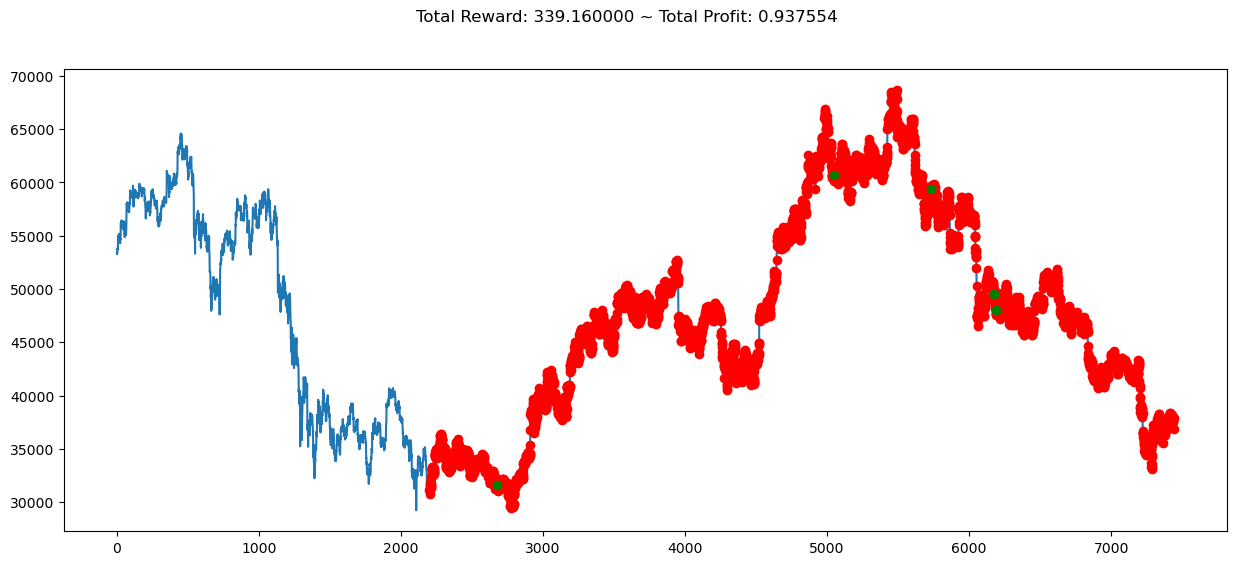

In [20]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()